## Imports

In [45]:
import os

# Set environment variables
os.environ["HF_HOME"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"
os.environ["HF_DATASETS_CACHE"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"
os.environ["TRANSFORMERS_CACHE"] = "/home/hice1/kpereira6/scratch/ConvAI/hf_cache"

# Verify the variables (optional)
print("HF_HOME:", os.environ.get("HF_HOME"))
print("HF_DATASETS_CACHE:", os.environ.get("HF_DATASETS_CACHE"))
print("TRANSFORMERS_CACHE:", os.environ.get("TRANSFORMERS_CACHE"))

HF_HOME: /home/hice1/kpereira6/scratch/ConvAI/hf_cache
HF_DATASETS_CACHE: /home/hice1/kpereira6/scratch/ConvAI/hf_cache
TRANSFORMERS_CACHE: /home/hice1/kpereira6/scratch/ConvAI/hf_cache


In [46]:
from transformers import SamModel, SamProcessor
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import torch
from sklearn.manifold import MDS
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
import os
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import random

### Load Model

#### ViT

In [47]:
# Load the CLIP model and processor
from transformers import AutoImageProcessor, ViTModel

# Load the CLIP model and processor
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


### Load Data

In [48]:
folders = os.listdir('./numerosity_project - All Stimuli')

In [49]:
folders

['Natural images plain_bg',
 'Equal area triangles',
 'Natural images plain_bg_blurred',
 'Natural images dinner',
 'Random shape random area',
 '.DS_Store',
 'Natural images',
 'Equal circumference circles',
 'Equal area squares',
 'Stimuli generation guide.docx',
 'Equal area circles',
 'Natural images dinner_blurred']

### Utils

In [50]:
def get_a_random_pic(folder_name,numerosity):
    #randomly choose an image of particular numerosity from any area/circumference for a class
    candidates = os.listdir(f'/content/drive/MyDrive/numerosity_project - All Stimuli/{folder_name}')
    folder_id = np.random.choice(candidates)
    folder_path = f'/content/drive/MyDrive/numerosity_project - All Stimuli/{folder_name}/{folder_id}/{numerosity}'
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return f'/content/drive/MyDrive/numerosity_project - All Stimuli/{folder_name}/{folder_id}/{numerosity}/'+ pic


In [51]:
def distance_effect(dist_matrix):
    print("\n\nDistance Effect")

    # 1: Distance Effect
    diff = defaultdict(list)

    # Get diff
    for i in range(0, 9):
        for j in range(i+1, 9):
            key = abs(i-j)
            diff[key].append(1 - dist_matrix[i][j])

    # Average
    for keys in diff:
        diff[keys] = np.mean(diff[keys])

    X = np.array([i for i in range(1, 9)])
    Y = np.array([diff[i] for i in range(1, 9)])

    corr, _ = pearsonr(X, Y)
    print(f'Pearsons correlation: {corr}')

    plt.figure(figsize=(10, 6))
    plt.xlabel("Numerical Difference between two numerosties |n1-n2|")
    plt.ylabel("Cosine Similarity")
    plt.scatter(X, Y)

    # Fit a line
    params = linregress(X, Y)
    slope, intercept = params.slope, params.intercept
    y_pred = slope * X + intercept

    fig, ax = plt.subplots()
    ax.scatter(X, Y, label='Data Points', color='blue')
    ax.plot(X, y_pred, label='Linear Fit', color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    # Print fitted parameters
    print("Fitted parameters:")
    print('Slope', slope)
    print('Intercept', intercept)

In [52]:
def size_effect(dist_matrix):
    print("\n\nSize Effect")

    # 2: Size Effect
    X = []
    Y = []

    size = defaultdict(list)
    for i in range(1, 10):
        for j in range(i+1, 10):
            key = (i+j) // 2
            size[key].append(1 - dist_matrix[i-1][j-1])

    # Average
    for keys in size:
        size[keys] = np.mean(size[keys])

    X = np.array(sorted(size.keys()))  # Sizes (average magnitude)
    Y = np.array([size[key] for key in X])

    corr, _ = pearsonr(X, Y)
    print(f'Pearsons correlation: {corr}')

    plt.figure(figsize=(10, 6))
    plt.xlabel("Size (n1+n2)/2")
    plt.ylabel("Cosine Similarity")
    plt.scatter(X, Y)

    params = linregress(X, Y)
    slope, intercept = params.slope, params.intercept
    y_pred = slope * X + intercept

    fig, ax = plt.subplots()
    ax.scatter(X, Y, label='Data Points', color='blue')
    ax.plot(X, y_pred, label='Linear Fit', color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    print("Fitted parameters:")
    print('Slope', slope)
    print('Intercept', intercept)


In [53]:
from scipy.optimize import curve_fit

def ratio_effect(dist_matrix):
    print("\n\nRatio Effect")

    # 3: Ratio Effect
    X = []
    Y = []
    for i in range(0, 9):
        for j in range(i+1, 9):
            X.append(max(i+1, j+1)/ min(i+1, j+1))
            Y.append(1 - dist_matrix[i][j])

    X = np.array(X)
    Y = np.array(Y)

    corr, _ = pearsonr(X, Y)
    print(f'Pearsons correlation: {corr}')

    plt.xlabel("Max/Min")
    plt.ylabel("Cosine Similarity")
    plt.scatter(X, Y)

    # Fit the curve (Exponential decay)
    params, covariance = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, X, Y, maxfev=1000000)

    # Extract fitted parameters
    a_fit, b_fit, c_fit = params
    y_pred = a_fit * np.exp(np.array(X)* - b_fit) + c_fit

    # Calculate R^2
    y_mean = np.mean(Y)
    ss_res = np.sum((Y - y_pred)**2)
    ss_tot = np.sum((Y - y_mean)**2)
    r_squared = 1 - (ss_res / ss_tot)

    print("R-squared value =", r_squared)

    # Plot the data points
    fig, ax = plt.subplots()
    plt.scatter(X, Y, label='Data Points', color='blue')

    # Plot the fitted curve
    x_fit = np.linspace(min(X), max(X), 100)
    y_fit = a_fit * np.exp(np.array(x_fit)* - b_fit) + c_fit
    plt.plot(x_fit, y_fit, label='Fitted Curve', color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()


In [54]:
path = f"./numerosity_project - All Stimuli/"

#### Experiments

### MDS

In [55]:
def handle_mds(M, category, n_comp = 1):
    plt.figure(figsize=(8, 6))
    if n_comp == 1:
        mds = MDS(n_components=1, dissimilarity="precomputed", random_state = 42)
        embedding = mds.fit_transform(M)
        stress = mds.stress_

        plt.scatter(embedding[:, 0], np.zeros_like(embedding[:, 0]), alpha=0.7, color='blue')
        for i in range(9):
            plt.text(embedding[i, 0], 0, f"{i+1}", fontsize=15, ha='right', va='center')
    elif n_comp == 2:
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state = 42)
        embedding = mds.fit_transform(M)
        stress = mds.stress_

        plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.7, color='blue')
        for i in range(9):
            plt.text(embedding[i, 0], embedding[i, 1], f"{i+1}", fontsize=15, ha='right', va='center')

    plt.title(f"MDS Visualization for {category}:\nStress: {stress}")
    plt.xlabel("1D Embedding")
    plt.yticks([])
    plt.grid(True, axis='x')
    plt.show()

### Experiment 1

In [56]:
def get_a_random_pic_for_exp1(folder_id,numerosity):
    #folder_id -> area
    #randomly choose an image of particular numerosity from any area class
    #circle select two from same area
    # candidates = os.listdir(f'/content/drive/MyDrive/numerosity_project - All Stimuli/Equal area circles')

    folder_path = f'./numerosity_project - All Stimuli/Equal area circles/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [57]:
get_a_random_pic_for_exp1('A1',1)

'./numerosity_project - All Stimuli/Equal area circles/A1/1/1_18.png'

In [58]:
def createNumerosityDistanceMatrix_Exp1(model, processor, device="cuda",M=20,Area='A2'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}

    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp1(Area,i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model(**img_inputs)
            pooled_output = img_embeddings.pooler_output
            temp_vectors.append(pooled_output.squeeze(0).cpu().numpy()) 
        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [59]:
dist_matrix = createNumerosityDistanceMatrix_Exp1(model,processor)

(768,)




Distance Effect
Pearsons correlation: -0.9495695602639646
Fitted parameters:
Slope -0.041583798671153936
Intercept 1.0439526400446486


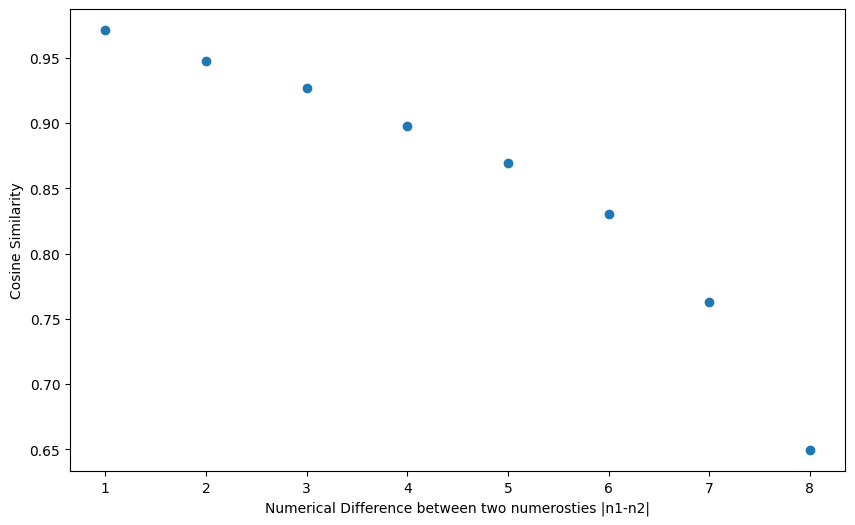

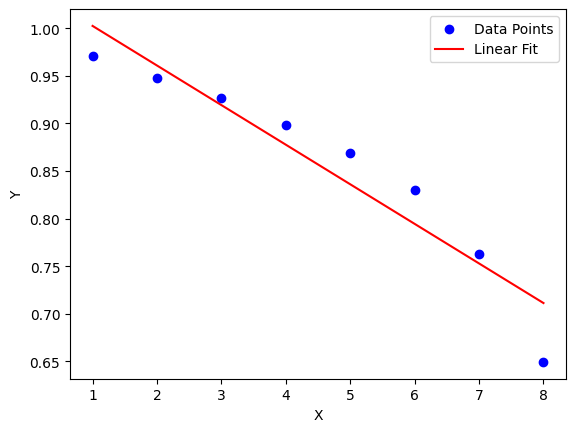

In [60]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.950522931546613
Fitted parameters:
Slope 0.026934139873165123
Intercept 0.7815574991865223


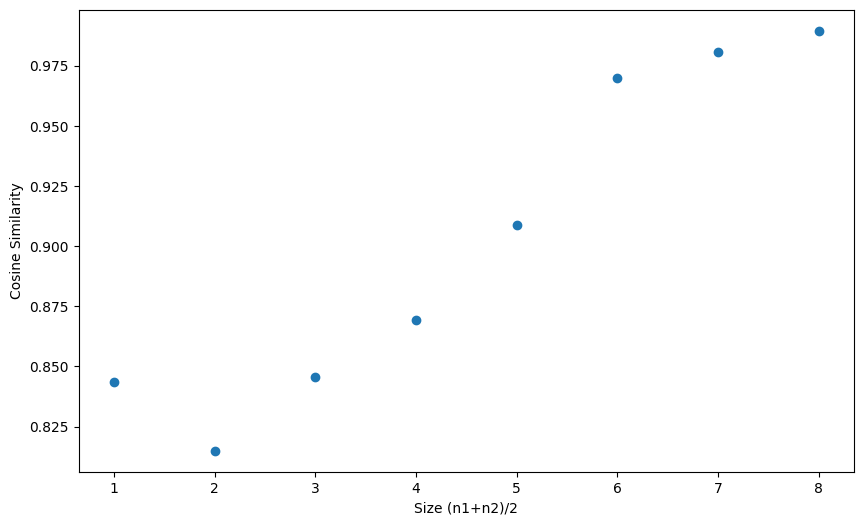

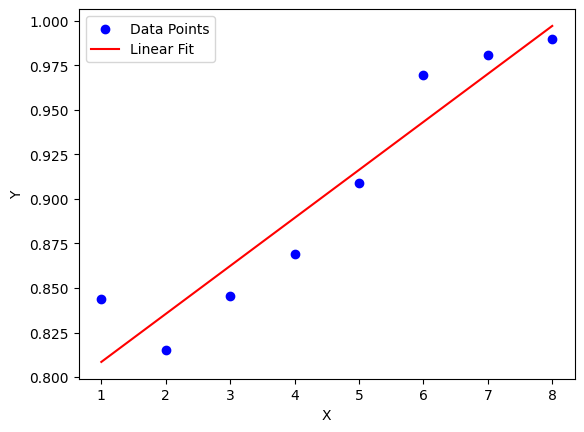

In [61]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.9151707435165739
R-squared value = 0.8535934161847922


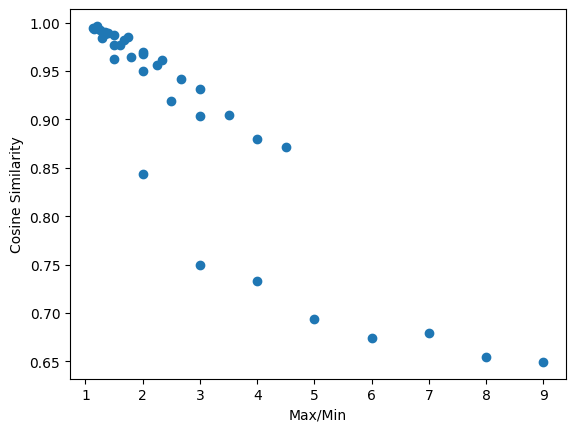

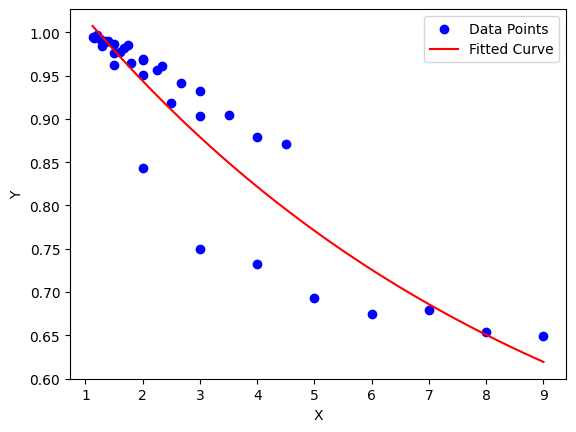

In [62]:
ratio_effect(dist_matrix)

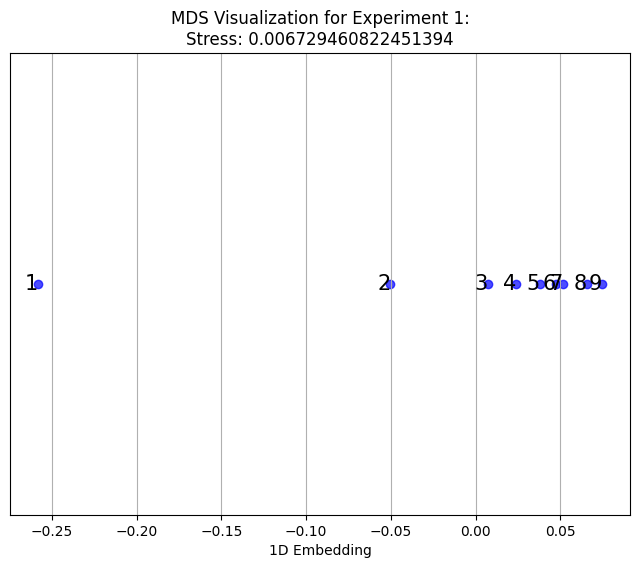

In [63]:
handle_mds(dist_matrix, "Experiment 1", n_comp = 1)

### Experiment 2

In [64]:
def get_a_random_pic_for_exp2(folder_id,numerosity):
    #folder_id -> area
    #randomly choose an image of particular numerosity from any area class
    #circle select two from same area
    # candidates = os.listdir(f'/content/drive/MyDrive/numerosity_project - All Stimuli/Equal area circles')

    folder_path = f'./numerosity_project - All Stimuli/Equal circumference circles/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [65]:
def createNumerosityDistanceMatrix_Exp2(model, processor, device="cuda",M=20,C='C1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}

    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp2(C,i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model(**img_inputs)
            pooled_output = img_embeddings.pooler_output
            temp_vectors.append(pooled_output.squeeze(0).cpu().numpy()) 
        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [66]:
dist_matrix = createNumerosityDistanceMatrix_Exp2(model,processor)

(768,)




Distance Effect
Pearsons correlation: -0.9647096372473276
Fitted parameters:
Slope -0.020971797006268077
Intercept 1.0156246046123862


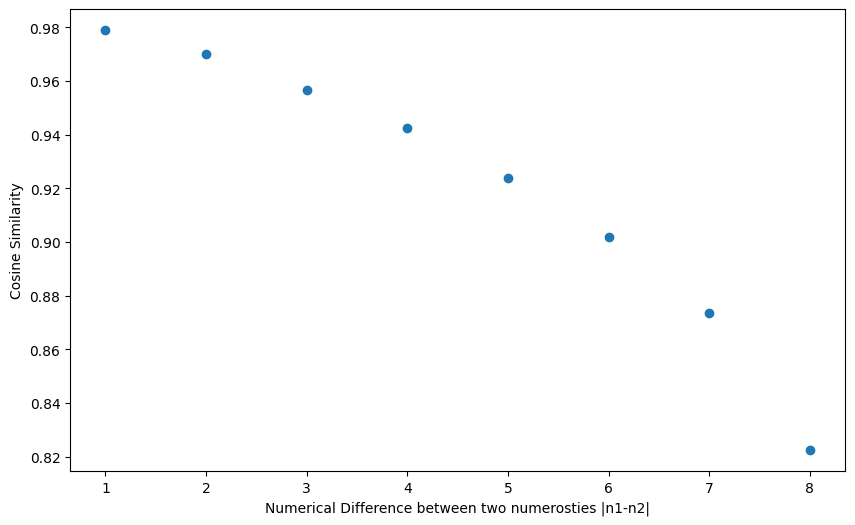

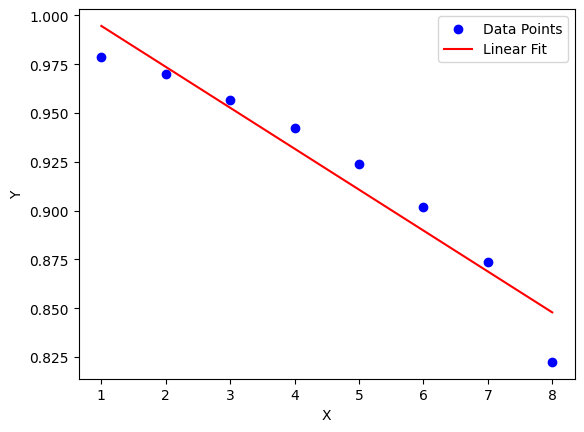

In [67]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.9819095327288841
Fitted parameters:
Slope 0.017934914389435126
Intercept 0.8594204675279506


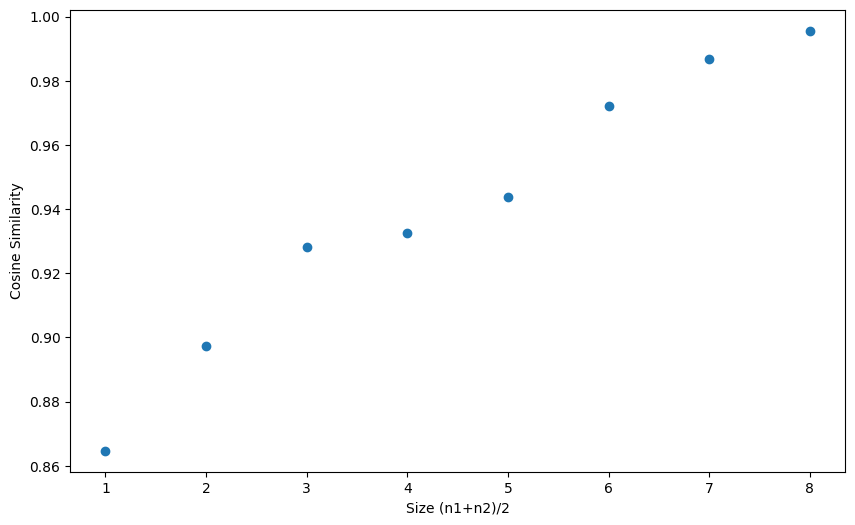

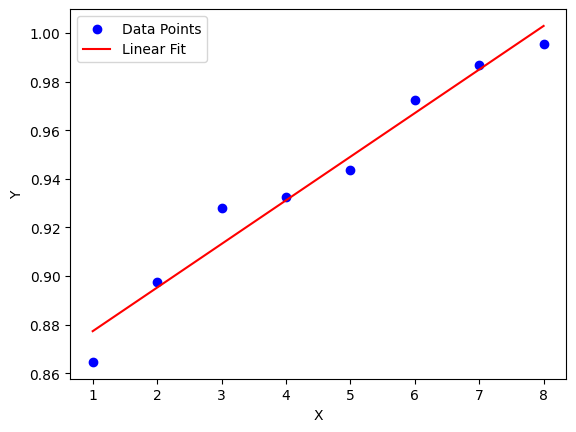

In [68]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.8750646400532196
R-squared value = 0.8008921329907104


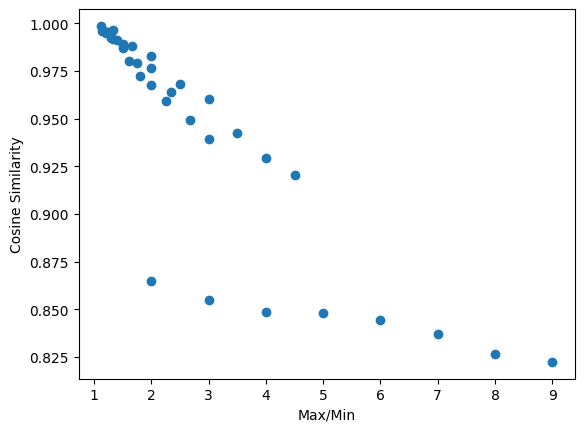

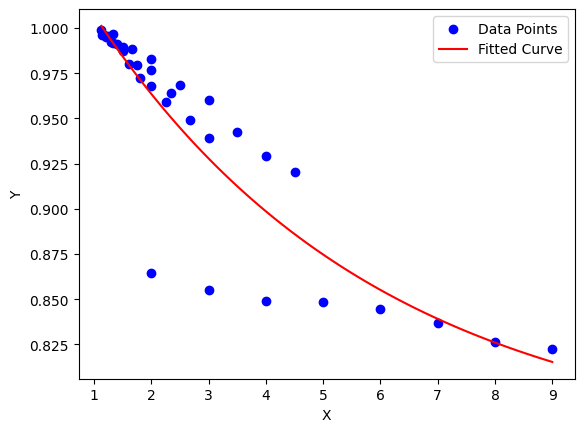

In [69]:
ratio_effect(dist_matrix)

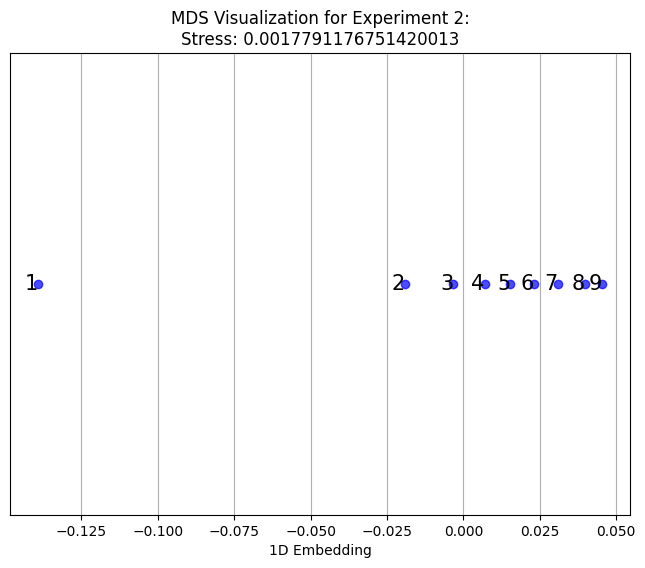

In [70]:
handle_mds(dist_matrix, "Experiment 2", n_comp = 1)

### Experiment 3

In [71]:
os.listdir('./numerosity_project - All Stimuli')

['Natural images plain_bg',
 'Equal area triangles',
 'Natural images plain_bg_blurred',
 'Natural images dinner',
 'Random shape random area',
 '.DS_Store',
 'Natural images',
 'Equal circumference circles',
 'Equal area squares',
 'Stimuli generation guide.docx',
 'Equal area circles',
 'Natural images dinner_blurred']

In [72]:
shapes = ['Equal area squares','Equal area circles','Equal area triangles']

In [73]:
def get_a_random_pic_for_exp3(folder_id,numerosity,shape):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/{shape}/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [74]:
def createNumerosityDistanceMatrix_Exp3(model, processor, device="cuda",M=20,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    shape_dict = {i: random.choice(shapes) for i in range(1, 10)}

    numerosity_vectors = {}

    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp3(A,i,shape_dict[i])
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model(**img_inputs)
            pooled_output = img_embeddings.pooler_output
            temp_vectors.append(pooled_output.squeeze(0).cpu().numpy()) # Move embeddings to CPU to avoid memory issues
# Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [75]:
dist_matrix = createNumerosityDistanceMatrix_Exp3(model,processor)

(768,)




Distance Effect
Pearsons correlation: -0.9604190593348911
Fitted parameters:
Slope -0.027154239459710867
Intercept 1.0005387479857524


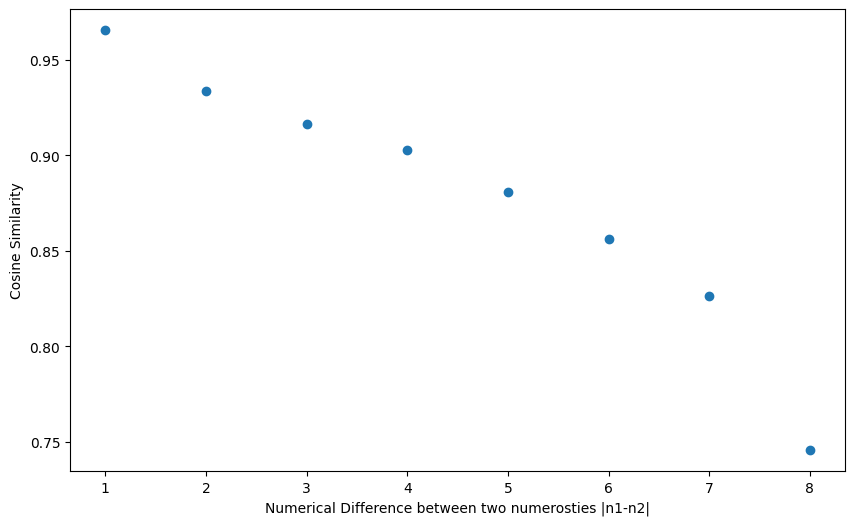

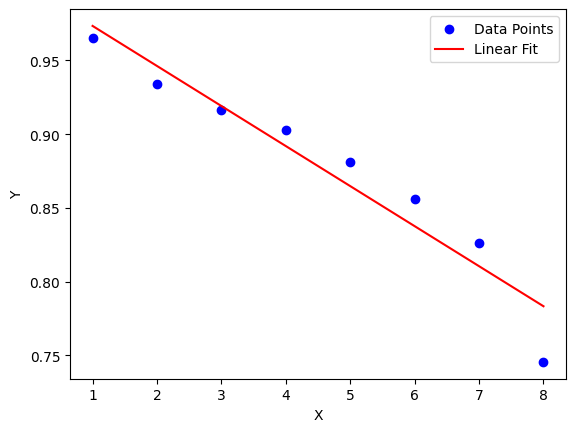

In [76]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.8468018908846985
Fitted parameters:
Slope 0.021381402863802017
Intercept 0.8151279049057538


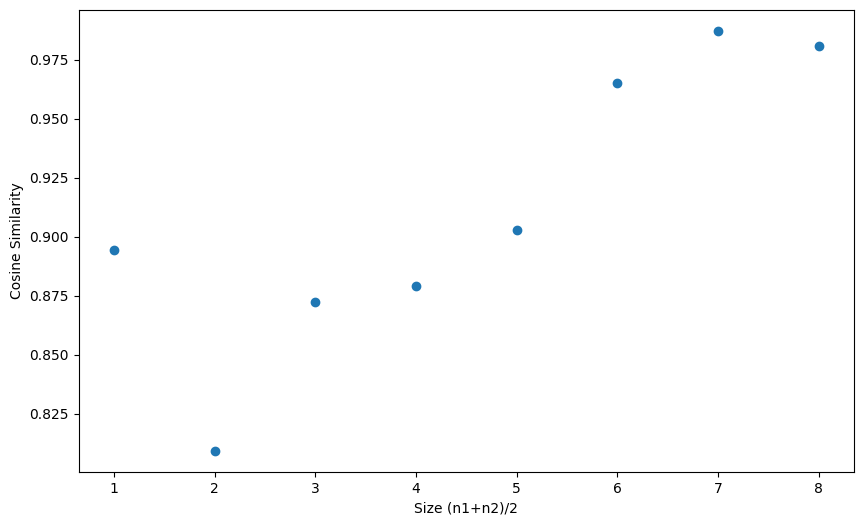

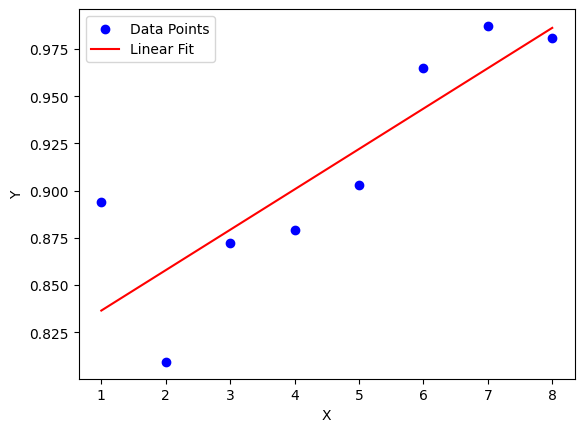

In [77]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.8643268392571023
R-squared value = 0.7883022103358874


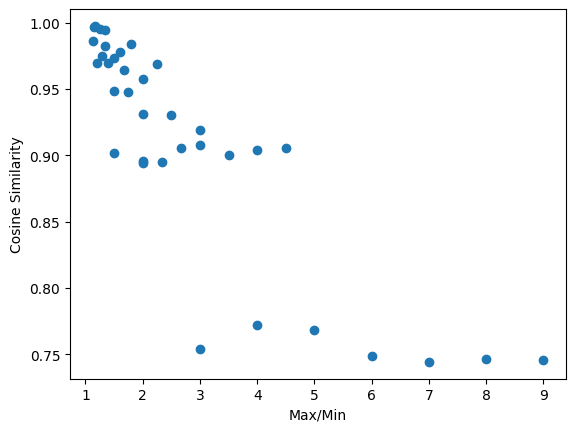

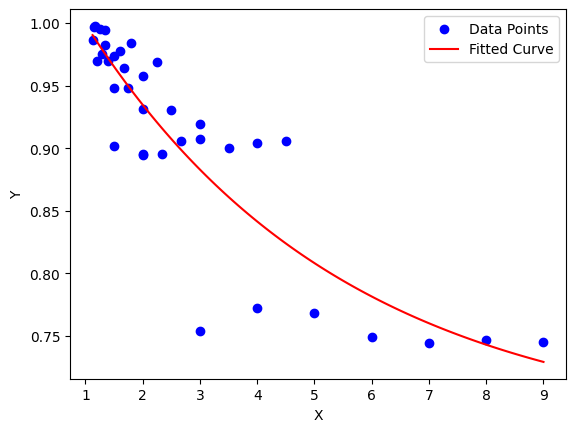

In [78]:
ratio_effect(dist_matrix)

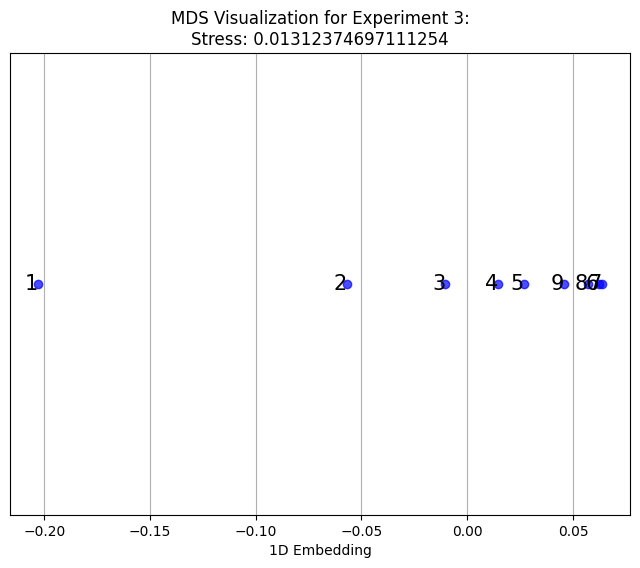

In [79]:
handle_mds(dist_matrix, "Experiment 3", n_comp = 1)

## Experiment 4


In [80]:
def get_a_random_pic_for_exp4(folder_id,numerosity,shape):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/{shape}/{folder_id}/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [81]:
def createNumerosityDistanceMatrix_Exp4(model, processor, device="cuda",M=40,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)
    shape_dict = {i: random.choice(shapes) for i in range(1, 10)}
    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess

            A = random.choice(['A1','A2','A3','A4','A5'])
            img_path = get_a_random_pic_for_exp4(A,i,shape_dict[i])
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model(**img_inputs)
            pooled_output = img_embeddings.pooler_output
            temp_vectors.append(pooled_output.squeeze(0).cpu().numpy())  # Move embeddings to CPU to avoid memory issues
 # Move embeddings to CPU to avoid memory issues

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [82]:
dist_matrix = createNumerosityDistanceMatrix_Exp4(model,processor)

(768,)




Distance Effect
Pearsons correlation: -0.9676410716048844
Fitted parameters:
Slope -0.028150861986538992
Intercept 0.9572121270102303


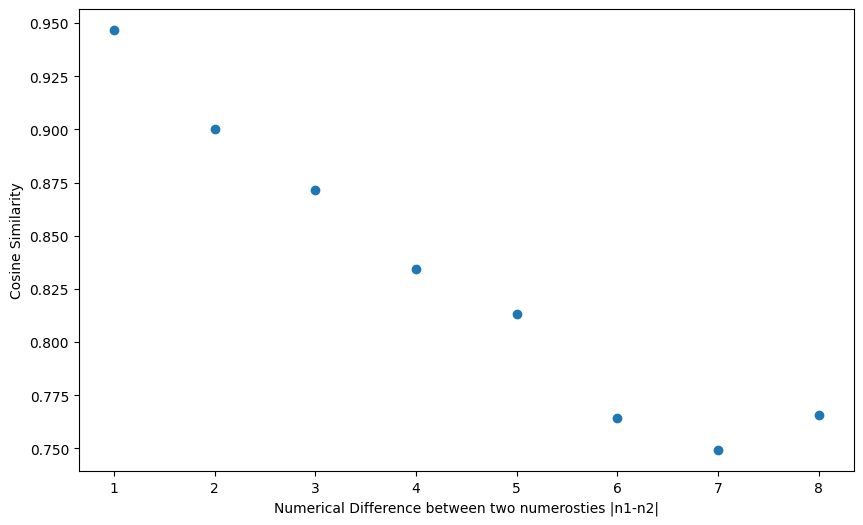

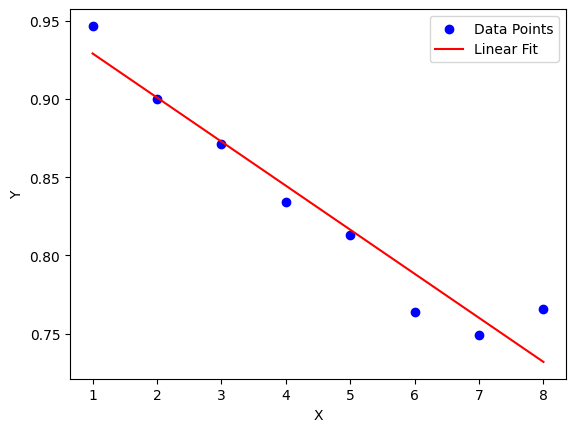

In [83]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.3807562448187728
Fitted parameters:
Slope 0.013047008272133717
Intercept 0.8074590408883128


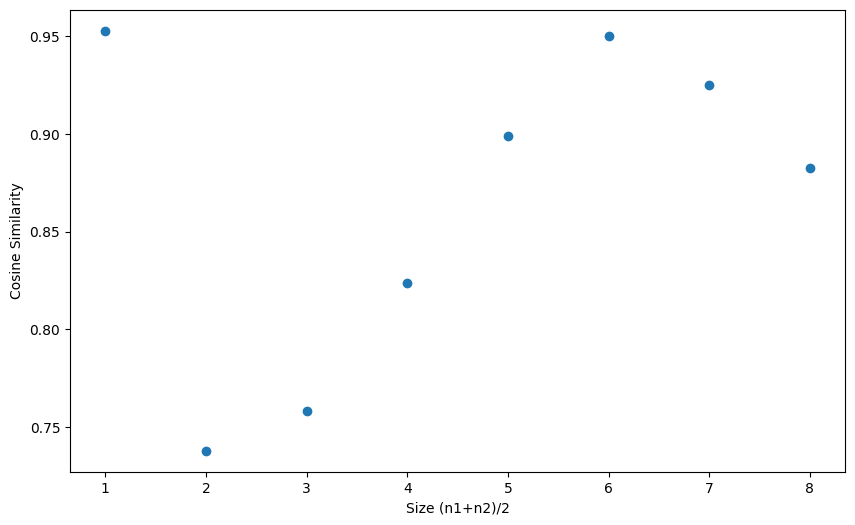

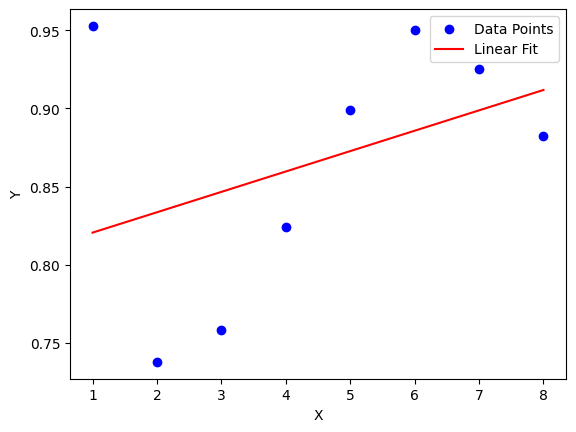

In [84]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.6763177385465529
R-squared value = 0.59087111451426


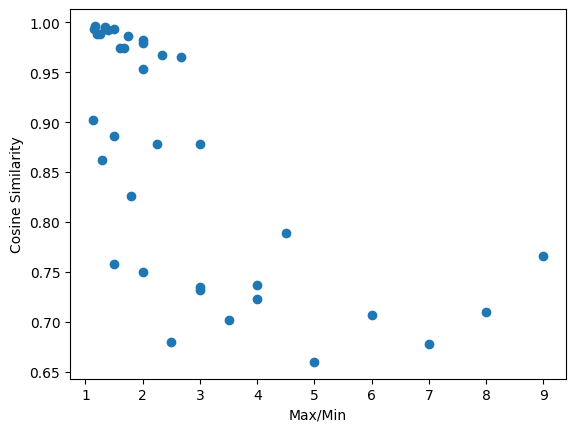

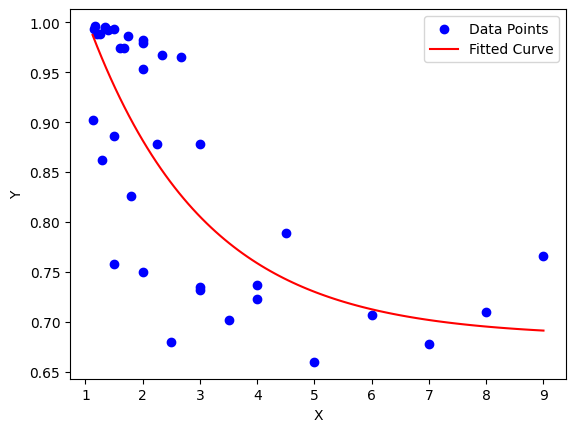

In [85]:
ratio_effect(dist_matrix)

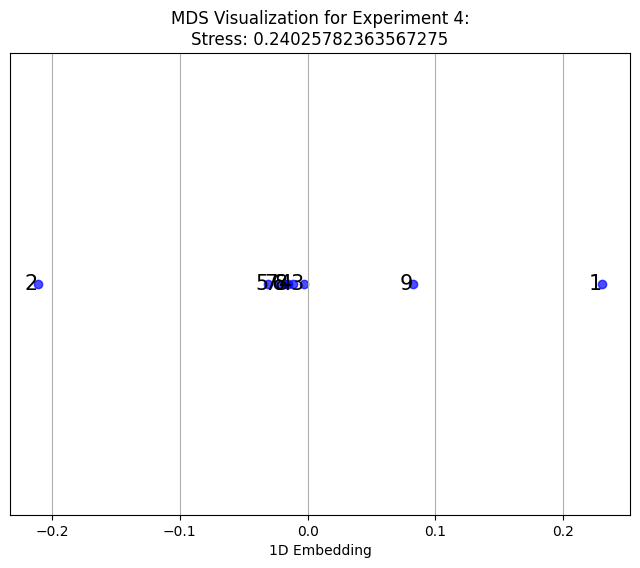

In [86]:
handle_mds(dist_matrix, "Experiment 4", n_comp = 1)

### Experiment 5

In [87]:
def get_a_random_pic_for_exp5(folder_id,numerosity,shape):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Random shape random area/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [88]:
def createNumerosityDistanceMatrix_Exp5(model, processor, device="cuda",M=60,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            shape = random.choice(['Equal area squares','Equal area circles','Equal area triangles'])
            A = random.choice(['A1','A2','A3','A4','A5'])
            img_path = get_a_random_pic_for_exp5(A,i,shape)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model(**img_inputs)
            pooled_output = img_embeddings.pooler_output
            temp_vectors.append(pooled_output.squeeze(0).cpu().numpy())  
        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [89]:
dist_matrix = createNumerosityDistanceMatrix_Exp5(model,processor)

(768,)




Distance Effect
Pearsons correlation: -0.987364710428311
Fitted parameters:
Slope -0.02746123514664011
Intercept 1.0236958179901652


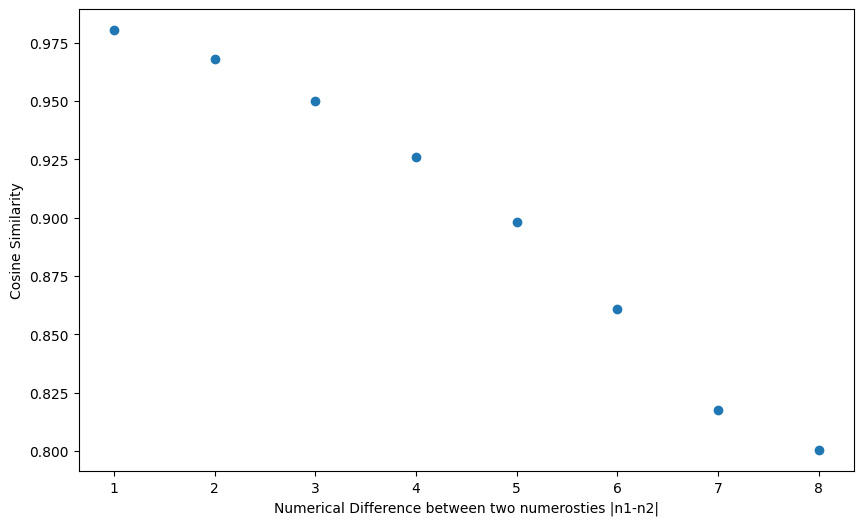

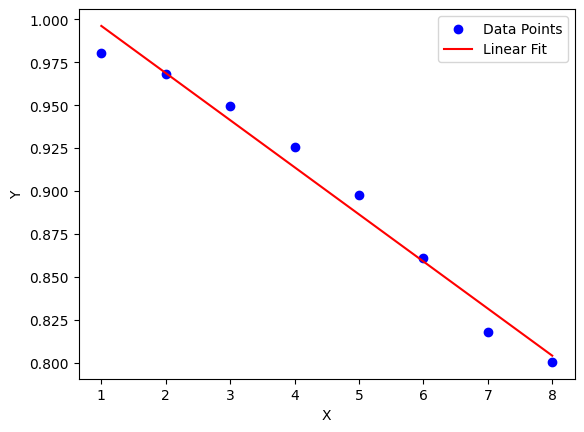

In [90]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.6940028138094547
Fitted parameters:
Slope 0.008732896754328085
Intercept 0.9009769093118557


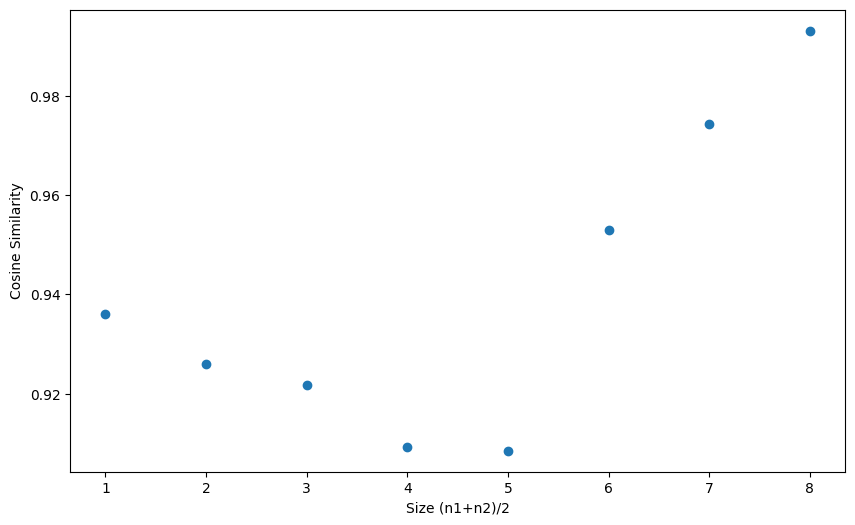

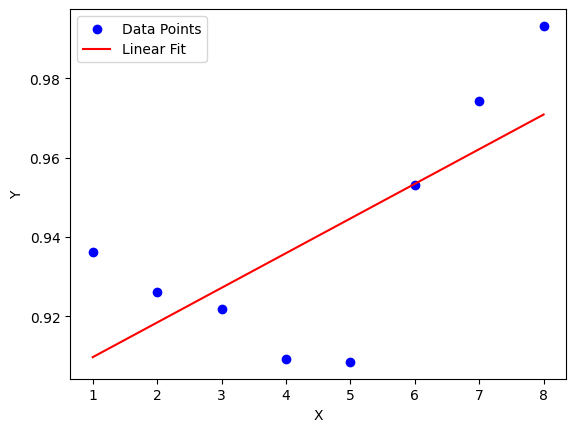

In [91]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.9351377483933748
R-squared value = 0.9460167461316775


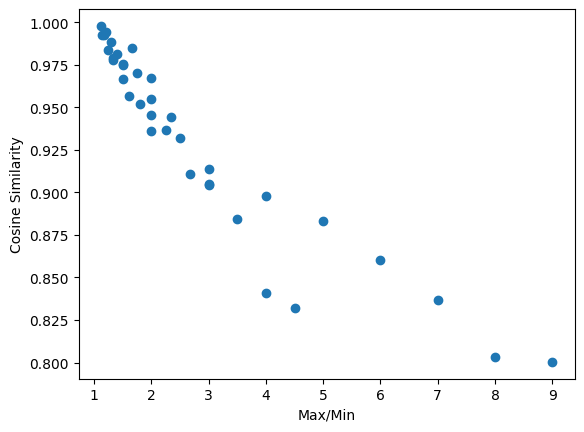

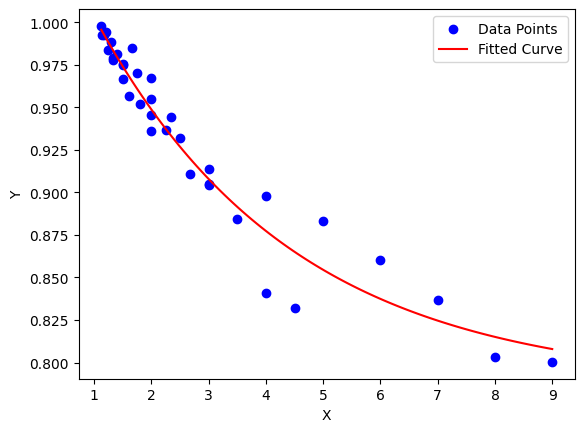

In [92]:
ratio_effect(dist_matrix)

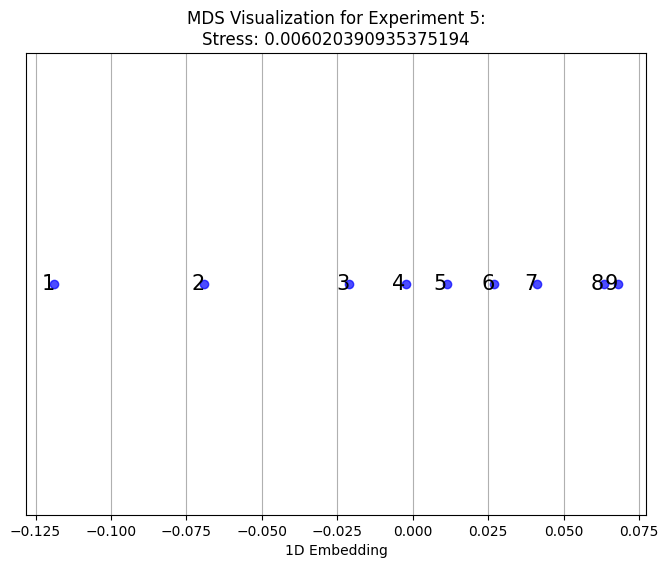

In [93]:
handle_mds(dist_matrix, "Experiment 5", n_comp = 1)

### Naturalistic Images (Exp6)

In [94]:
def get_a_random_pic_for_exp6(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


In [95]:
def createNumerosityDistanceMatrix_Exp6(model, processor, device="cuda",M=40,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_a_random_pic_for_exp6(i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model(**img_inputs)
            pooled_output = img_embeddings.pooler_output
            temp_vectors.append(pooled_output.squeeze(0).cpu().numpy()) 
        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [96]:
dist_matrix = createNumerosityDistanceMatrix_Exp6(model,processor)

(768,)




Distance Effect
Pearsons correlation: -0.9515675766333405
Fitted parameters:
Slope -0.01158786421882457
Intercept 0.9354034929099131


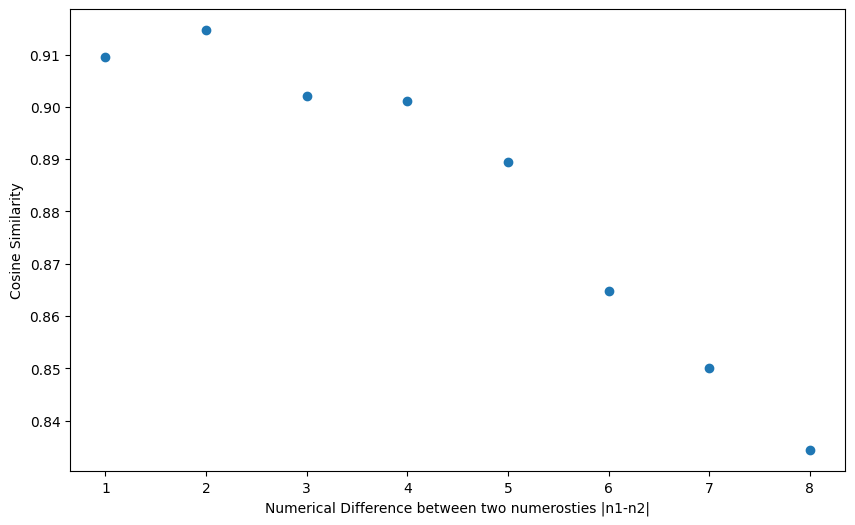

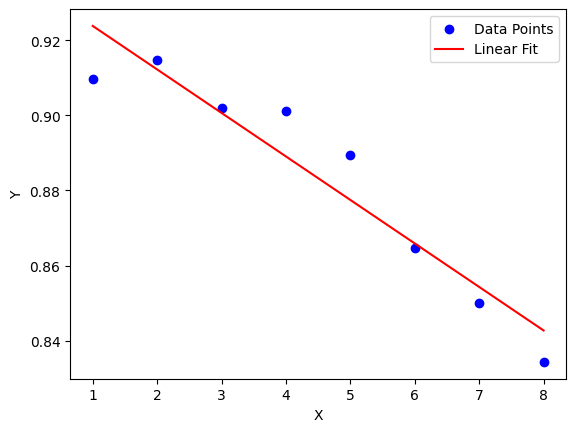

In [97]:
distance_effect(dist_matrix)



Size Effect
Pearsons correlation: 0.7915288306879111
Fitted parameters:
Slope 0.005822839241584683
Intercept 0.871925081789088


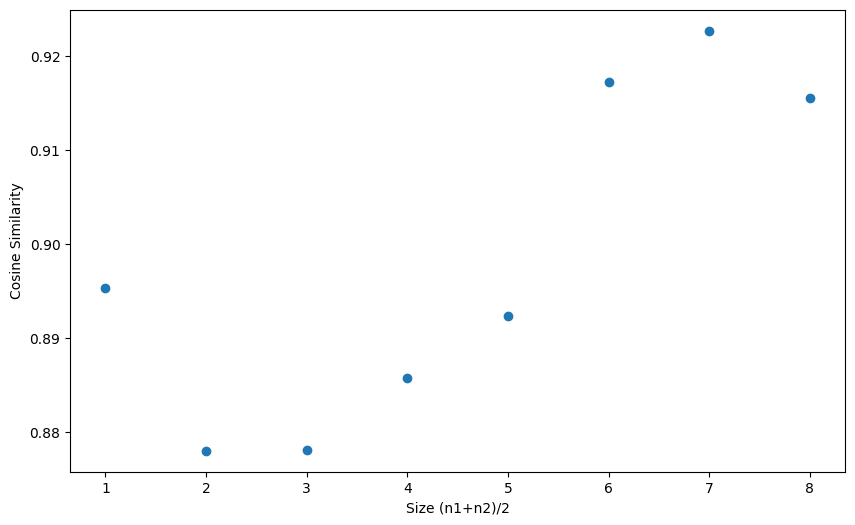

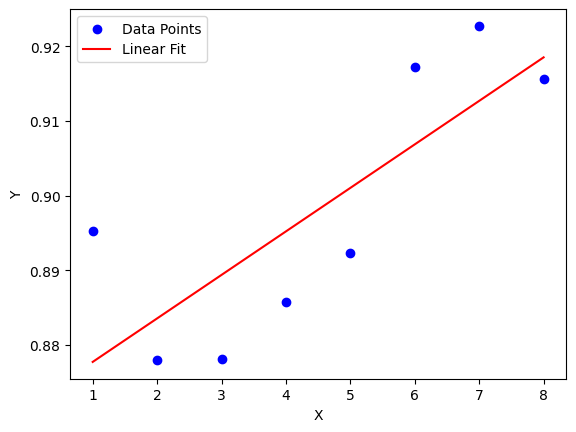

In [98]:
size_effect(dist_matrix)



Ratio Effect
Pearsons correlation: -0.8376354614131912
R-squared value = 0.745090500249086


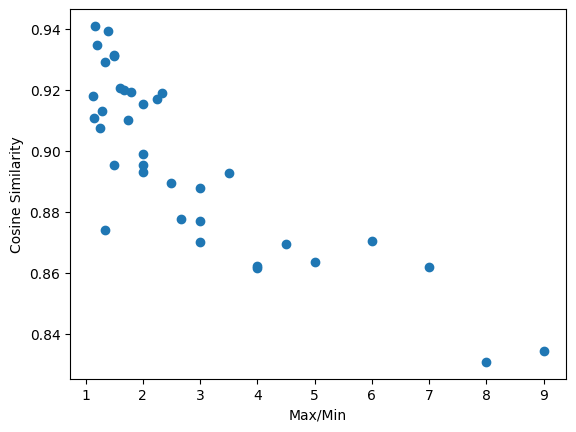

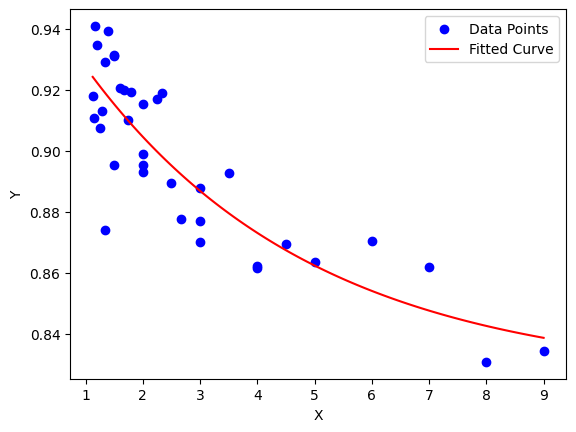

In [99]:
ratio_effect(dist_matrix)

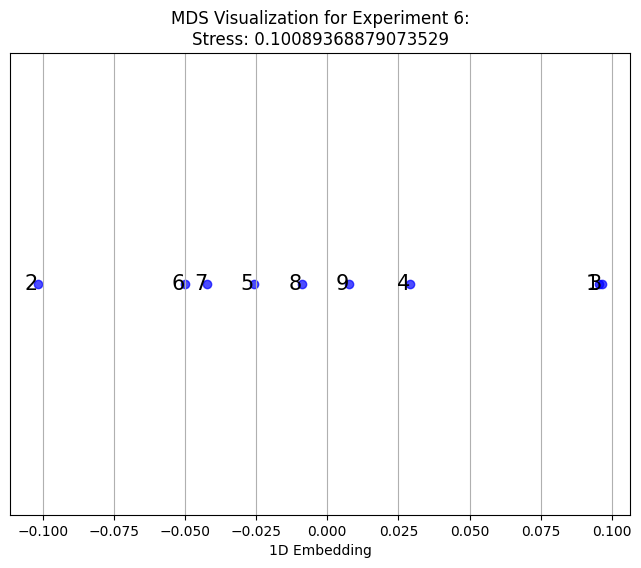

In [100]:
handle_mds(dist_matrix, "Experiment 6", n_comp = 1)

#### Experiments with added background



In [101]:
### Natural images bg plain

def get_a_random_pic_for_exp7(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images plain_bg/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic

def get_a_random_pic_for_exp8(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images plain_bg_blurred/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


def get_a_random_pic_for_exp9(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images dinner/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic


def get_a_random_pic_for_exp10(numerosity):
    #for a particualr stimuli fix a shape
    #stimuli area controlled

    folder_path = f'./numerosity_project - All Stimuli/Natural images dinner_blurred/{numerosity}'
    # pic_candidates = os.listdir(folder_path)

    #choose two random mage from this area folder
    pic = str(np.random.choice(os.listdir(folder_path),1)[0])
    return folder_path+'/'+ pic



In [102]:
def createNumerosityDistanceMatrix_Exp(model, processor,get_image, device="cuda",M=40,A='A1'):
    """
    Create a numerosity distance matrix based on embeddings generated by a model.

    Args:
        folder_name (str): Name of the folder containing images.
        folder_id (str): ID of the subfolder.
        model: Pretrained model to generate image embeddings.
        processor: Processor to preprocess images for the model.
        path (str): Base path to the image folders.
        device (str): Device to run the computation on ("cuda" for GPU, "cpu" otherwise).

    Returns:
        np.ndarray: A 9x9 matrix of cosine distances between numerosity embeddings.
    """
    # Move the model to the specified device
    model = model.to(device)

    numerosity_vectors = {}
    for i in range(1, 10):
        temp_vectors = []
        for k in range(M):
            # Load image and preprocess
            img_path = get_image(i)
            img = Image.open(img_path).convert("RGB")
            img_inputs = processor(images=img, return_tensors="pt").to(device)  # Send to GPU

            # Generate embeddings
            with torch.no_grad():
                img_embeddings = model(**img_inputs)
            pooled_output = img_embeddings.pooler_output
            temp_vectors.append(pooled_output.squeeze(0).cpu().numpy()) 

        # Compute the mean embedding for this numerosity
        temp_vectors = np.array(temp_vectors)
        numerosity_vectors[i] = np.mean(temp_vectors, axis=0)

    print(numerosity_vectors[1].shape)
    # Initialize distance matrix
    numerosity_distance_matrix = np.zeros((9, 9))

    # Compute pairwise cosine distances
    for i in range(1, 10):
        for j in range(1, 10):
            if i != j:
                numerosity_distance_matrix[i-1][j-1] = cosine(numerosity_vectors[i], numerosity_vectors[j])

    return numerosity_distance_matrix

In [103]:

exp7 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp7)
exp8 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp8)
exp9 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp9)
exp10 = createNumerosityDistanceMatrix_Exp(model,processor,get_a_random_pic_for_exp10)

(768,)
(768,)
(768,)
(768,)


#### Experiment 7 results



Distance Effect
Pearsons correlation: -0.8990875825987771
Fitted parameters:
Slope -0.01185281216135236
Intercept 0.9507805370301211


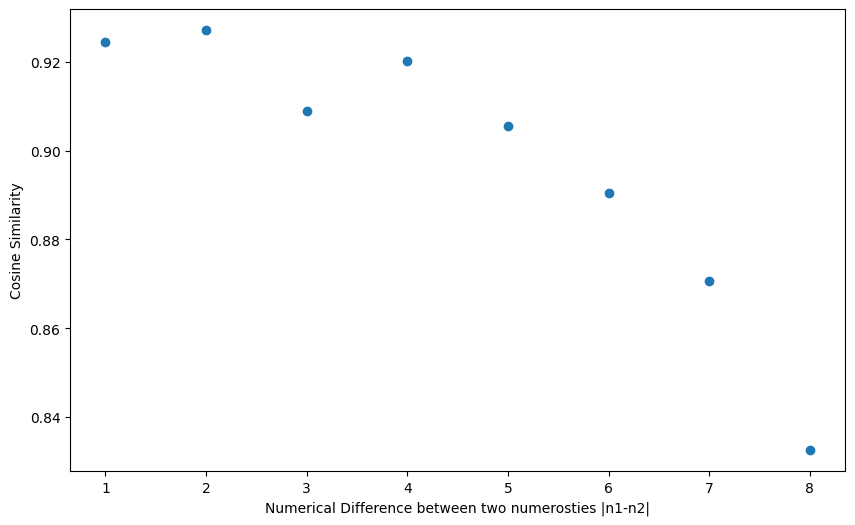

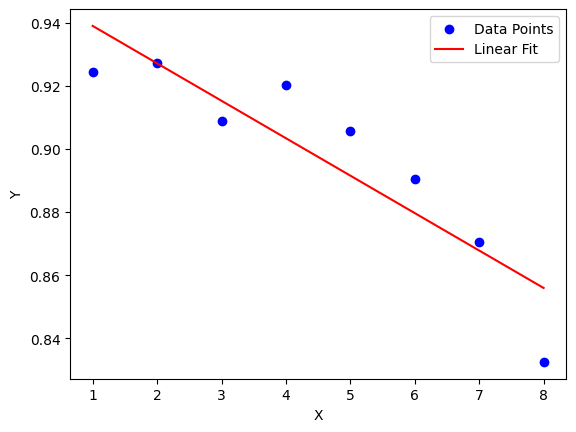

In [104]:
distance_effect(exp7)



Size Effect
Pearsons correlation: 0.8530285253496097
Fitted parameters:
Slope 0.00695829705045877
Intercept 0.8818857969374073


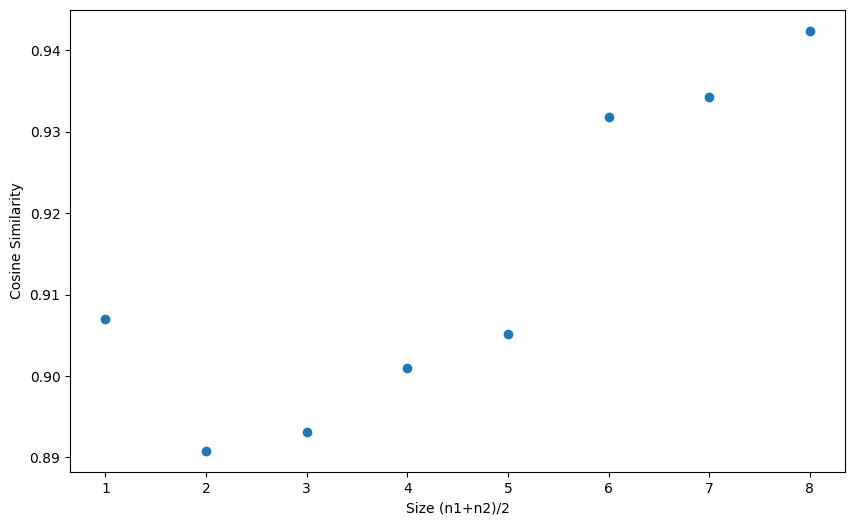

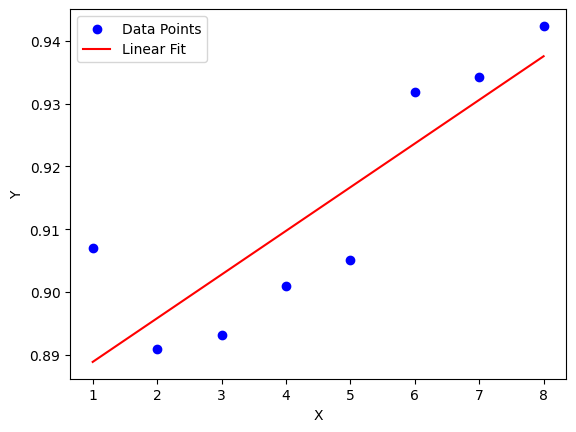

In [105]:
size_effect(exp7)



Ratio Effect
Pearsons correlation: -0.8196932296160395
R-squared value = 0.6734075888230684


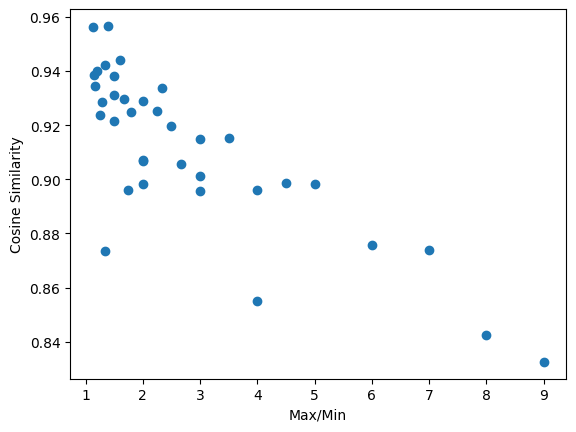

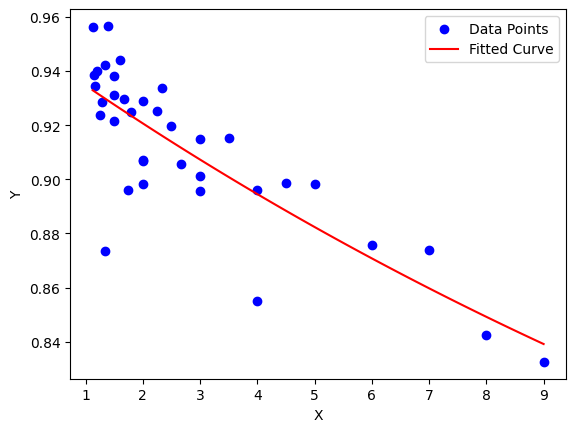

In [106]:
ratio_effect(exp7)

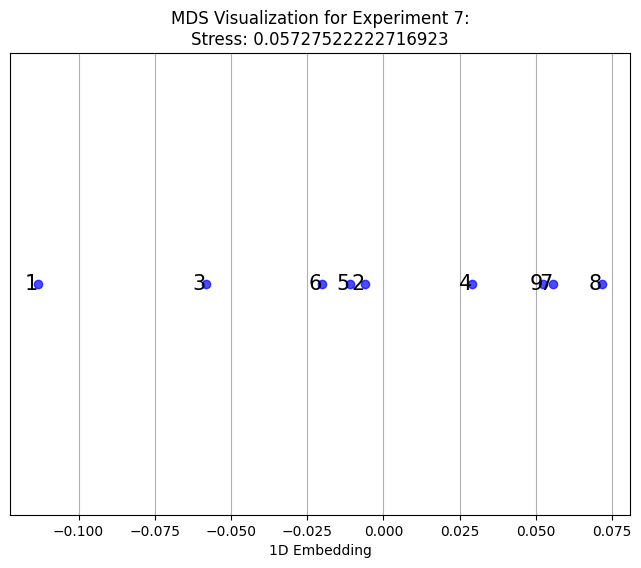

In [107]:
handle_mds(exp7, "Experiment 7", n_comp = 1)

### Experiment 8 results



Distance Effect
Pearsons correlation: -0.8995712417569077
Fitted parameters:
Slope -0.014914125351070543
Intercept 0.9513553021615053


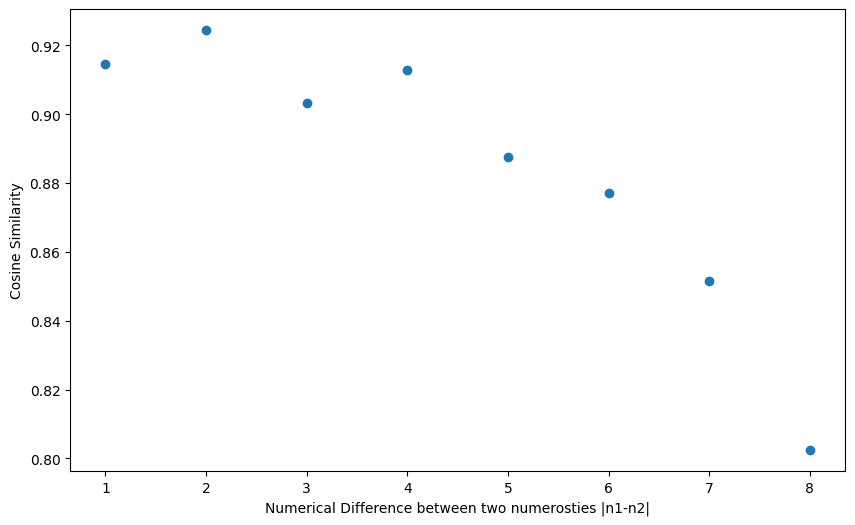

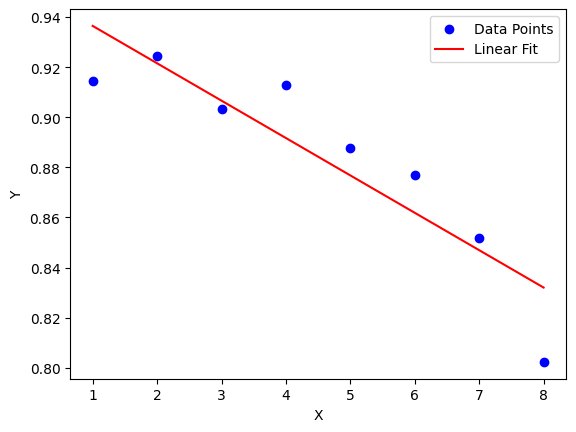

In [108]:
distance_effect(exp8)



Size Effect
Pearsons correlation: 0.9483130363719172
Fitted parameters:
Slope 0.007826803160869344
Intercept 0.865238956240367


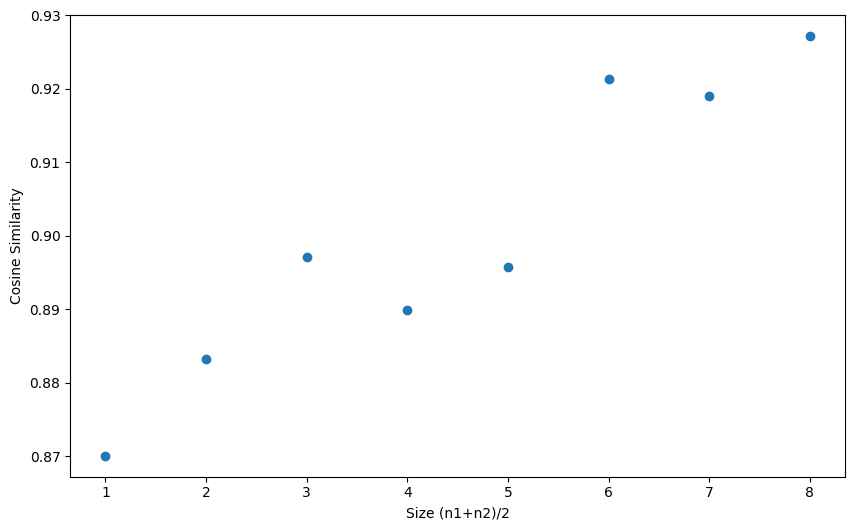

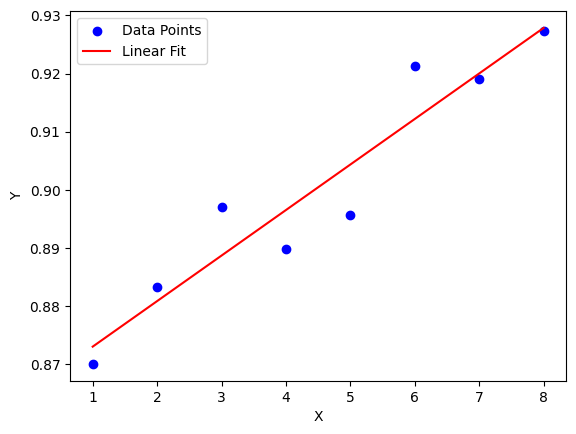

In [109]:
size_effect(exp8)



Ratio Effect
Pearsons correlation: -0.8473702806294701
R-squared value = 0.7180315452421169


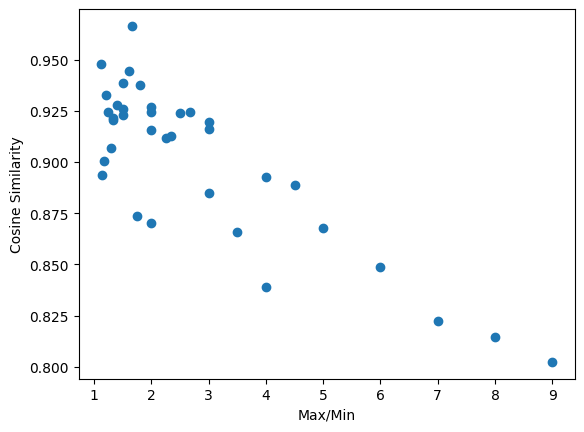

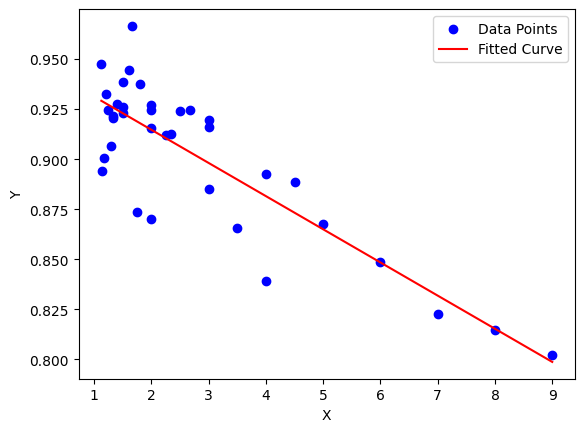

In [110]:
ratio_effect(exp8)

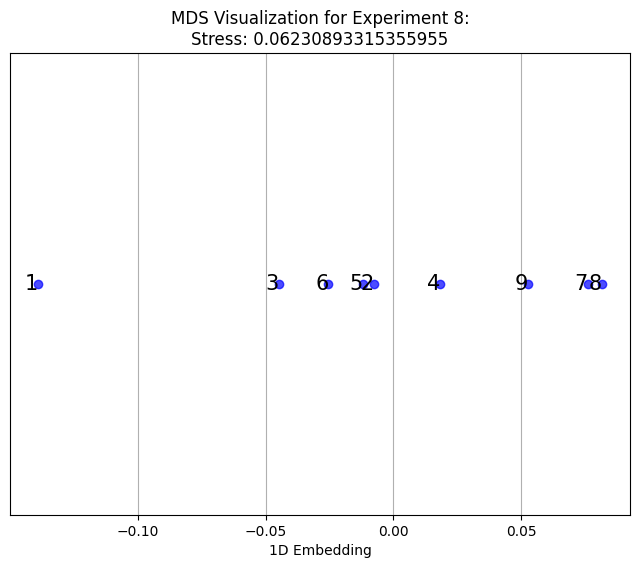

In [111]:
handle_mds(exp8, "Experiment 8", n_comp = 1)

#### Experiment 9



Distance Effect
Pearsons correlation: -0.8899524959309415
Fitted parameters:
Slope -0.011555533554582368
Intercept 0.9575810828024434


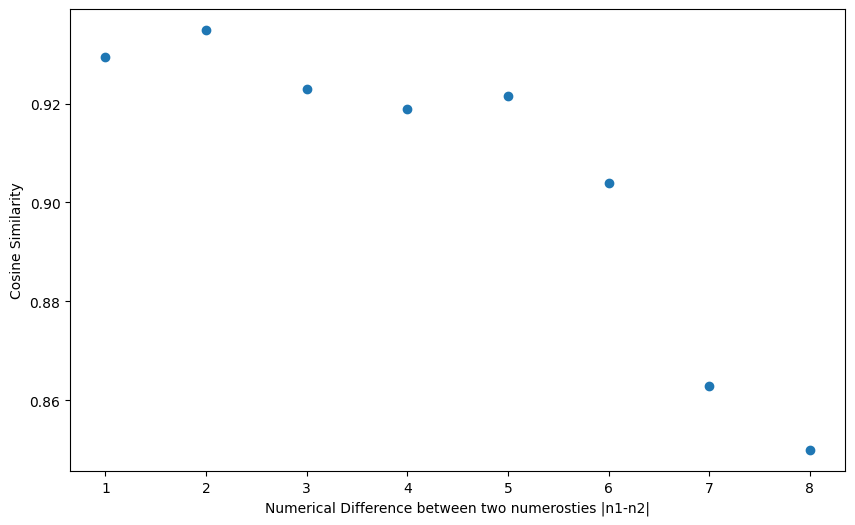

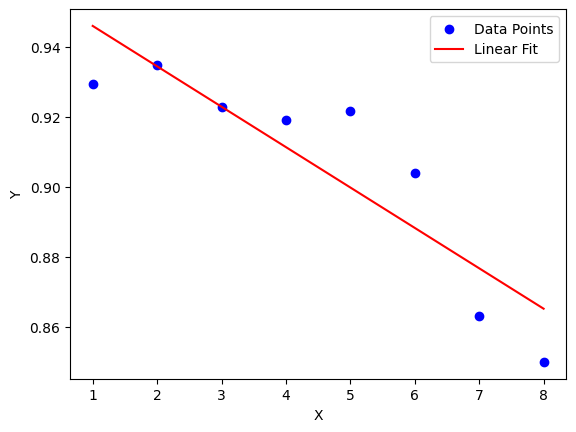

In [112]:
distance_effect(exp9)



Size Effect
Pearsons correlation: 0.6467134942310884
Fitted parameters:
Slope 0.0025513031120811204
Intercept 0.9082313252701647


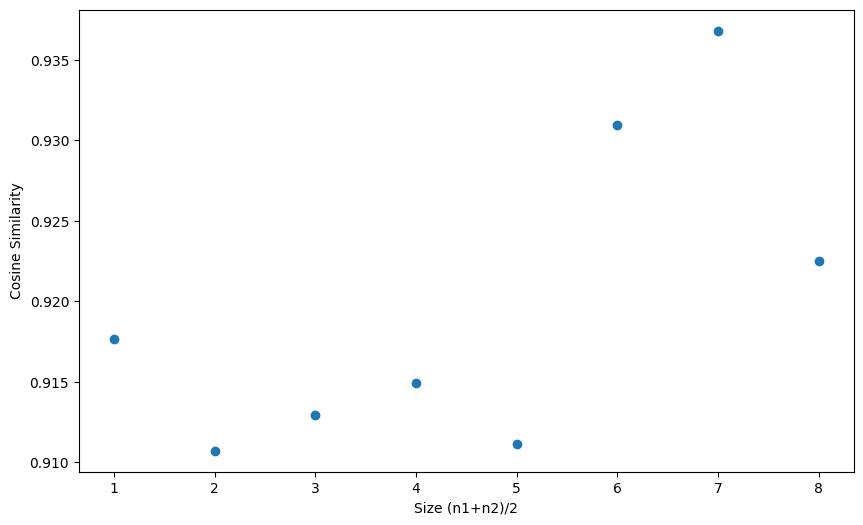

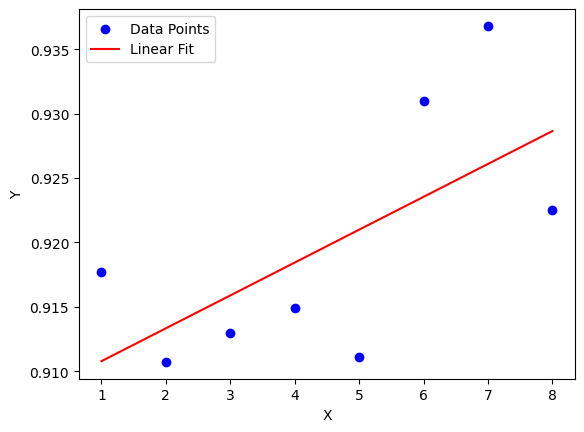

In [113]:
size_effect(exp9)



Ratio Effect
Pearsons correlation: -0.7927604045463794
R-squared value = 0.6285725288634343


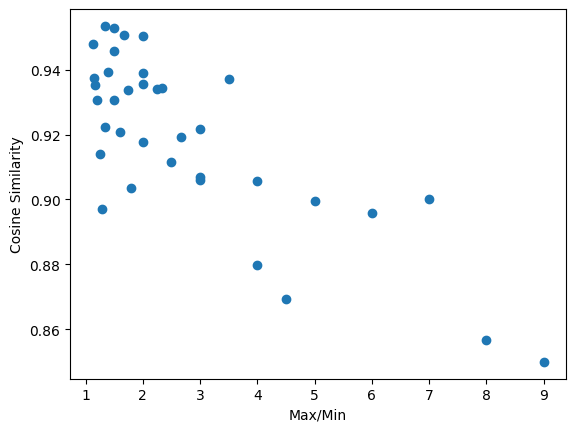

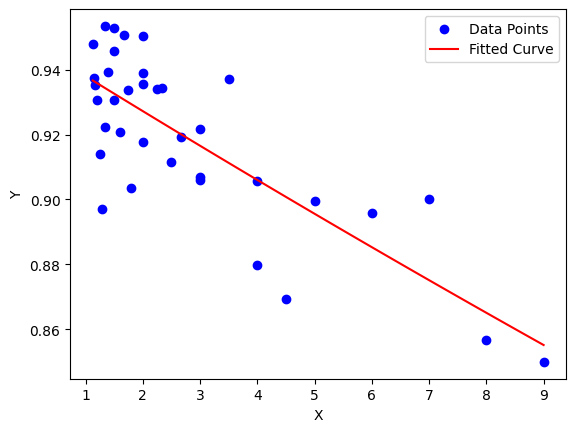

In [114]:
ratio_effect(exp9)

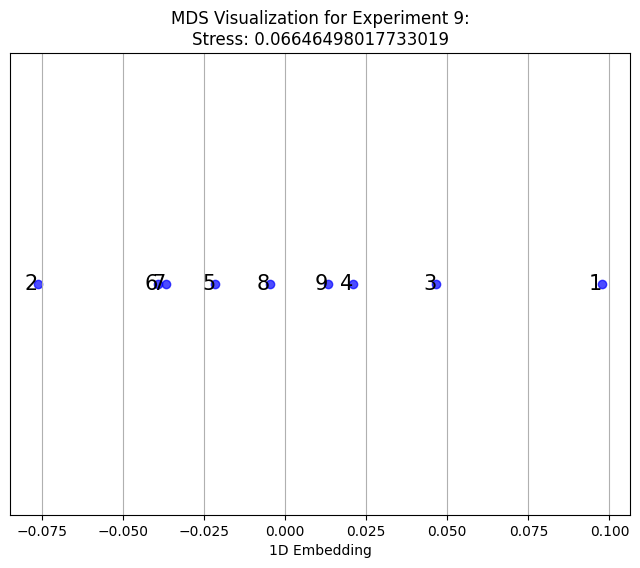

In [115]:
handle_mds(exp9, "Experiment 9", n_comp = 1)

### Experiment 10



Distance Effect
Pearsons correlation: -0.9426202209989896
Fitted parameters:
Slope -0.009470863457845183
Intercept 0.936346361426269


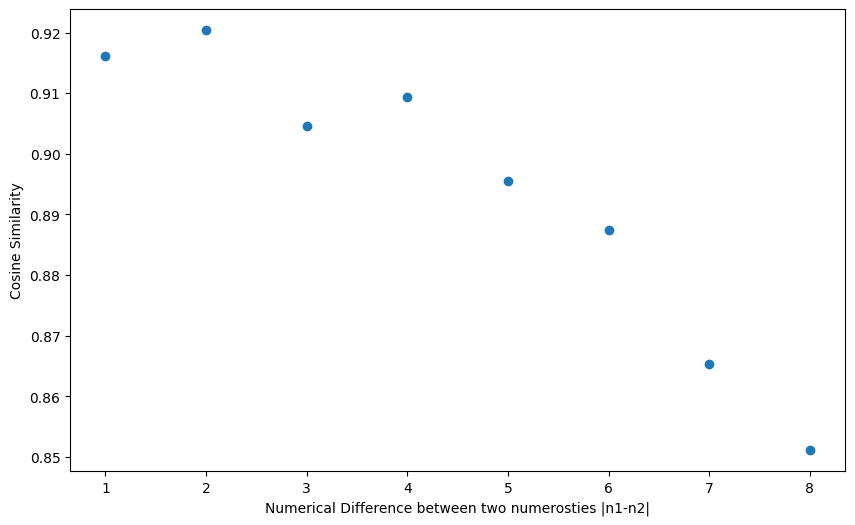

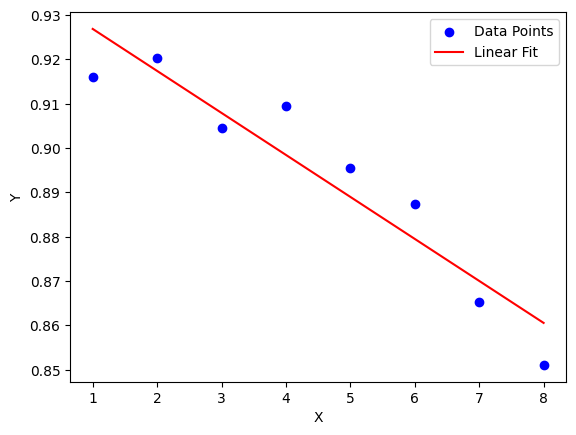

In [116]:
distance_effect(exp10)



Size Effect
Pearsons correlation: 0.7454574814599579
Fitted parameters:
Slope 0.004718768088962219
Intercept 0.886703235199865


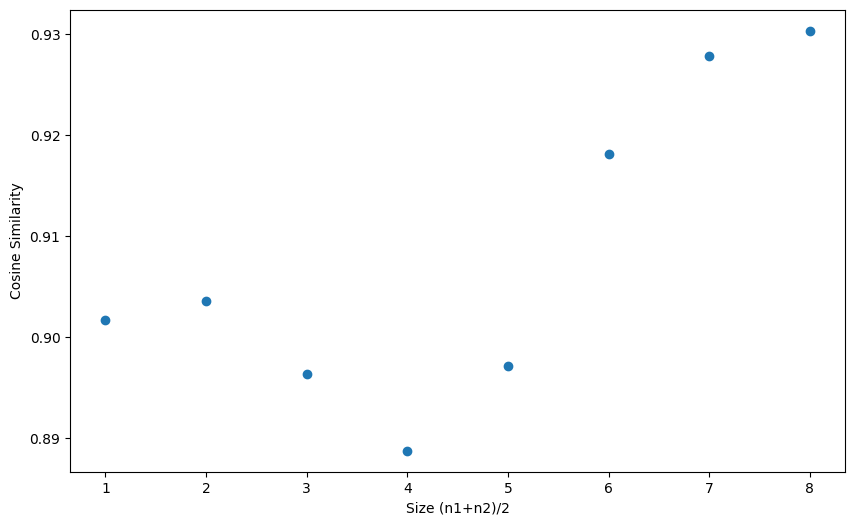

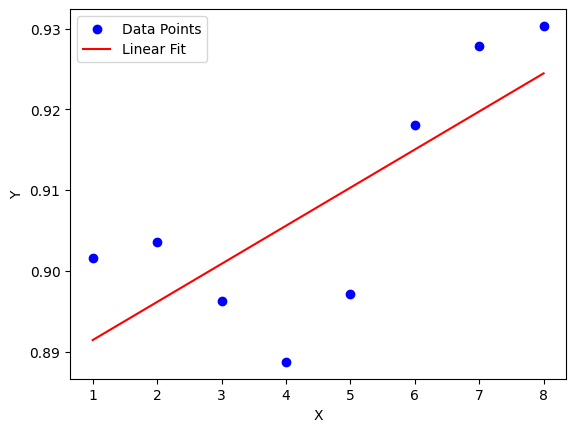

In [117]:
size_effect(exp10)



Ratio Effect
Pearsons correlation: -0.8981772366561886
R-squared value = 0.8070479988655264


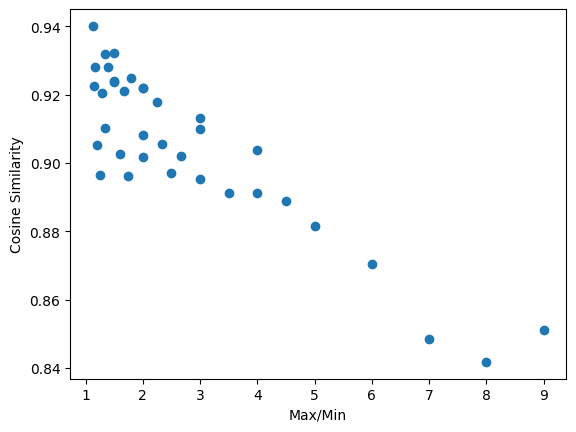

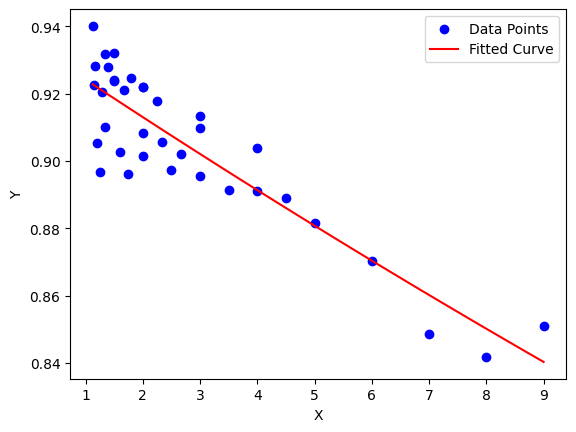

In [118]:
ratio_effect(exp10)

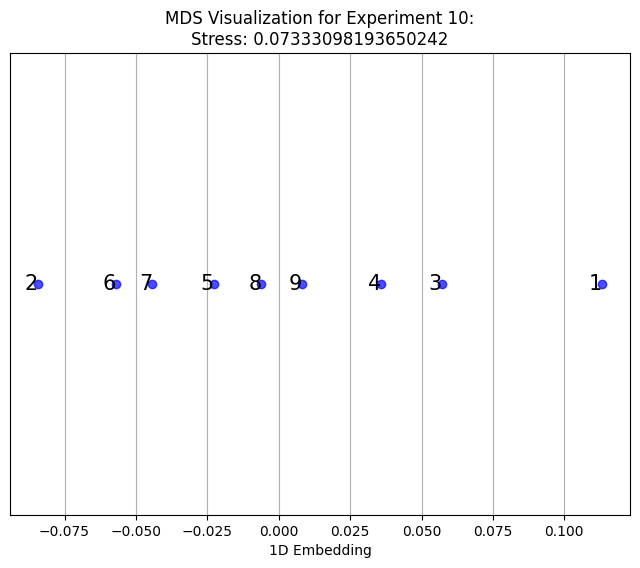

In [119]:
handle_mds(exp10, "Experiment 10", n_comp = 1)